# **EduExcluders: When Data Plays the Role of the Gatekeeper in Schools**

---
This notebook contains experiments for a black mirror scenario where educational institutions screen students based on their background. The data is is first analysed. A classification model is created to carry out this scenrio. We also apply at least two Explainable AI methods which are then evaluated and compared. We then use these results to provide recommendations for the future

The prospective student data is provided from https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# Exploratory Data analysis

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

In [2]:
base_dir = 'data/'

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')

  base_dir = '/content/drive/MyDrive/Maastricht University/MSc/Notes/Year 1/Period 4/XAI/XAI-Project/'
except ImportError:
  pass

In [4]:
data_file = 'data.csv'

In [5]:
# Read the data
data = pd.read_csv(f'{base_dir}{data_file}',sep=";")

## Getting Aquainted with the dataset

In [6]:
# Get the first 5 entries
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [7]:
# Information about the size of the dataset and its datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [8]:
# Printining the amount of unique values in each column
data.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance\t                        2
Previous qualification                             17
Previous qualification (grade)                    101
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                32
Father's occupation                                46
Admission grade                                   620
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder          

Now that we have explored each of these, we can say the following about the data we have,

Categorical features include: Marital Status, Application mode, Application order, Course, Daytime/evening attendance, Previous qualification, Nacionality, Mother's qualification, Father's qualification, Mother's occupation, Father's occupation, Displaced, Educational special needs, Debtor, Tuition fees up to date, Gender, Scholarship holder, International

Numeric: Previous qualification (grade), Admission grade, Age at enrollment, Curricular units 1st/2nd sem (credited),  Curricular units 1st/2nd sem (enrolled), Curricular units 1st/2nd sem (evaluations), Curricular units 1st/2nd sem (approved), Curricular units 1st/2nd sem (grade), Curricular units 1st/2nd sem (without evaluations), Unemployment rate, Inflation rate, GDP

Outcome: Target (categorical)

## Data Imbalance

In [9]:
imbalance_check = data['Target'].value_counts().reset_index()

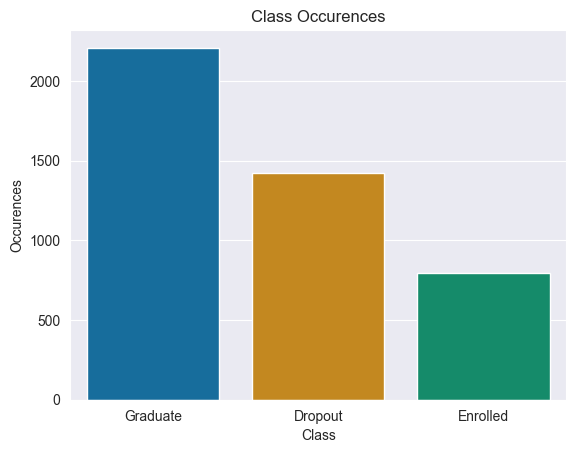

In [10]:
data_balance_fig = sns.barplot(x = "Target", y = "count", data = imbalance_check, palette='colorblind', hue="Target")
plt.ylabel('Occurences')
plt.xlabel('Class')
plt.title("Class Occurences")
plt.show(data_balance_fig)

Looking at the above graph, we can clearly see that we are working with imbalanced data, with Graduated students containing the majority of the dataset.

Although, this imbalance may not necessarily be significant between graduate & dropout (**NOTE**: Provide proof of this).

Addressing the class imbalance may therefore be necessary to ensure model performance and generalization across all classes. This could be done through under and over-sampling techniques such as SMOTE.



In [11]:
imbalance_fix = data.copy()
imbalance_fix.loc[imbalance_fix['Target'] != 'Graduate', 'Target'] = 'NotGraduate'
imbalance_check = imbalance_fix['Target'].value_counts().reset_index()
print(imbalance_check)

        Target  count
0  NotGraduate   2215
1     Graduate   2209


In [12]:
data['BinaryTarget'] = imbalance_fix['Target']
print(data)

      Marital status  Application mode  Application order  Course   
0                  1                17                  5     171  \
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance\t  Previous qualification   
0                                1                       1  \
1                                1             

## Univariate Analysis

Explore each feature, analyze its distribution and examine summary statistics.

(-1.0999997620636128,
 1.0999997669968569,
 -1.134999858404027,
 1.8349970346214626)

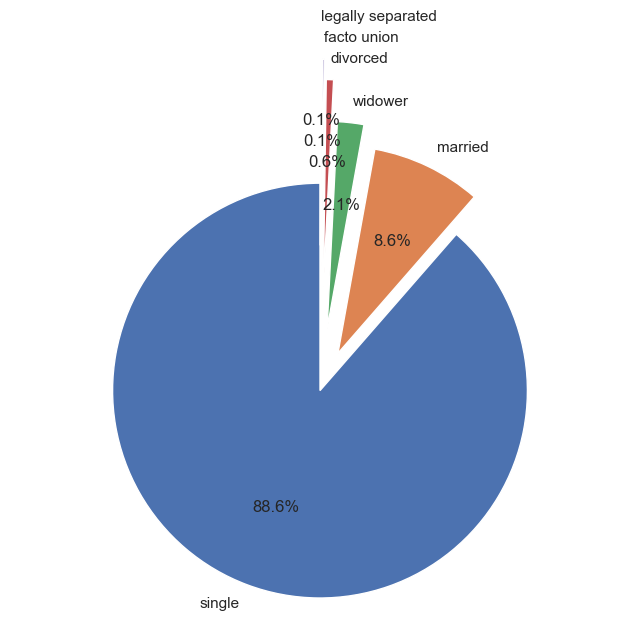

In [13]:
sns.set(rc={'figure.figsize': (8, 8)})
mapping = {
  1: 'single',
  2: 'married',
  3: 'widower',
  4: 'divorced',
  5: 'facto union',
  6: 'legally separated'
}

explode = [0, 0.2, 0.3, 0.5, 0.6, 0.7]
# Replace values in the marital status column
marital_status = data['Marital status'].replace(mapping).value_counts()
plt.pie(marital_status, explode=explode, labels=mapping.values(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

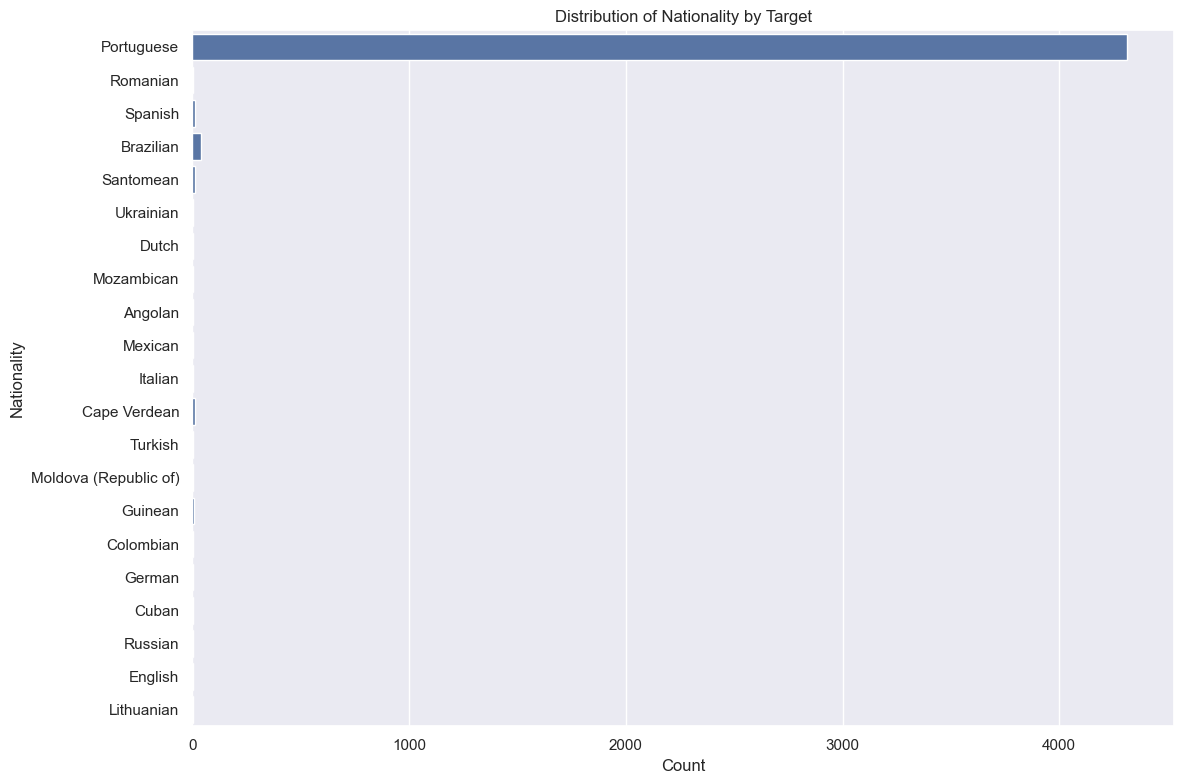

In [14]:
nationality_mapping = {
    1: 'Portuguese',
    2: 'German',
    6: 'Spanish',
    11: 'Italian',
    13: 'Dutch',
    14: 'English',
    17: 'Lithuanian',
    21: 'Angolan',
    22: 'Cape Verdean',
    24: 'Guinean',
    25: 'Mozambican',
    26: 'Santomean',
    32: 'Turkish',
    41: 'Brazilian',
    62: 'Romanian',
    100: 'Moldova (Republic of)',
    101: 'Mexican',
    103: 'Ukrainian',
    105: 'Russian',
    108: 'Cuban',
    109: 'Colombian'
}

# Replace values in the 'Nationality' column using the mapping
nacionality = data['Nacionality'].replace(nationality_mapping)
nacionality = pd.DataFrame({'Nacionality': nacionality, 'Target': data['Target']})

# Plotting the count plot for 'Nationality' with hue and separated plots
plt.figure(figsize=(12, 8))
sns.countplot(data=nacionality, y='Nacionality')
plt.title('Distribution of Nationality by Target')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.tight_layout()
plt.show()

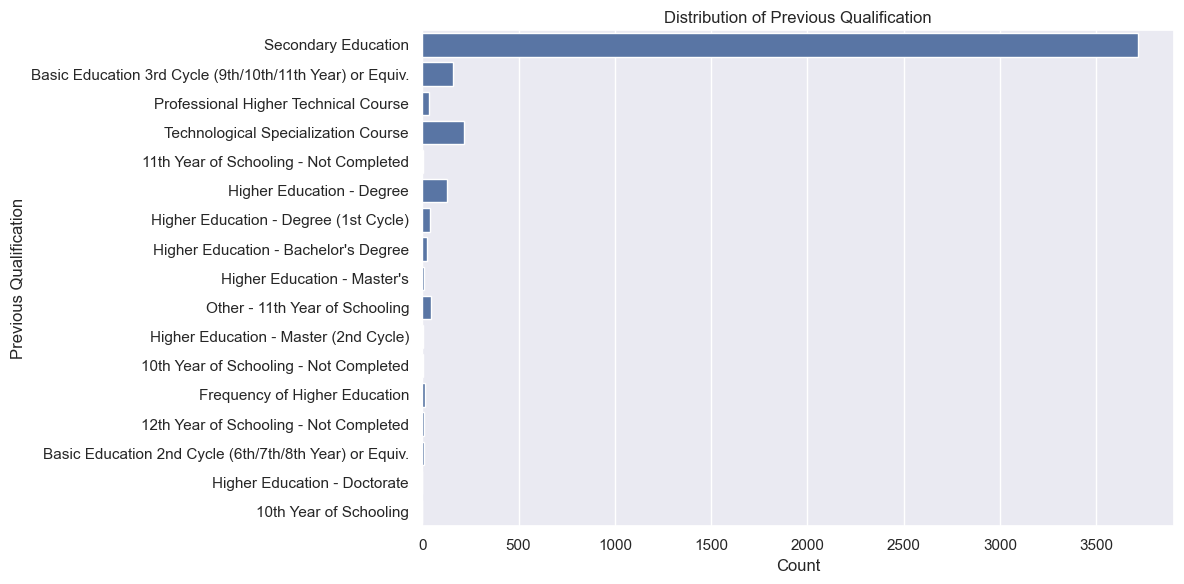

In [15]:
mapping_prev_qualification = {
    1: 'Secondary Education',
    2: "Higher Education - Bachelor's Degree",
    3: 'Higher Education - Degree',
    4: "Higher Education - Master's",
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    12: 'Other - 11th Year of Schooling',
    14: '10th Year of Schooling',
    15: '10th Year of Schooling - Not Completed',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological Specialization Course',
    40: 'Higher Education - Degree (1st Cycle)',
    42: 'Professional Higher Technical Course',
    43: 'Higher Education - Master (2nd Cycle)'
}

prev_qualification = data['Previous qualification'].replace(mapping_prev_qualification)
prev_qualification_with_target = pd.DataFrame({'Previous Qualification': prev_qualification, 'Target': data['Target']})

plt.figure(figsize=(12, 6))
sns.countplot(data=prev_qualification_with_target, y='Previous Qualification')
plt.title('Distribution of Previous Qualification')
plt.xlabel('Count')
plt.ylabel('Previous Qualification')
plt.tight_layout()
plt.show()

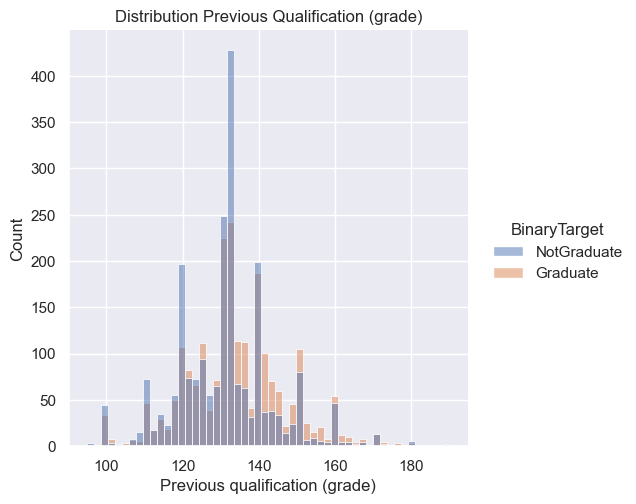

In [21]:
sns.displot(data, x=data['Previous qualification (grade)'], hue=data.BinaryTarget)
plt.title('Distribution Previous Qualification (grade)')
plt.show()

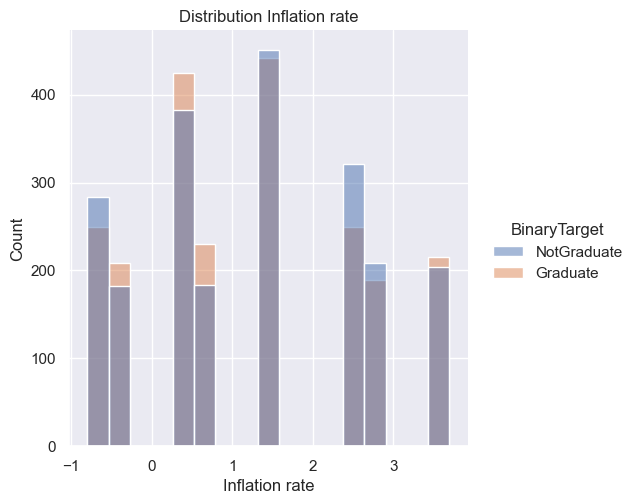

In [24]:
sns.displot(data, x=data['Inflation rate'], hue=data.BinaryTarget)
plt.title('Distribution Inflation rate')
plt.show()

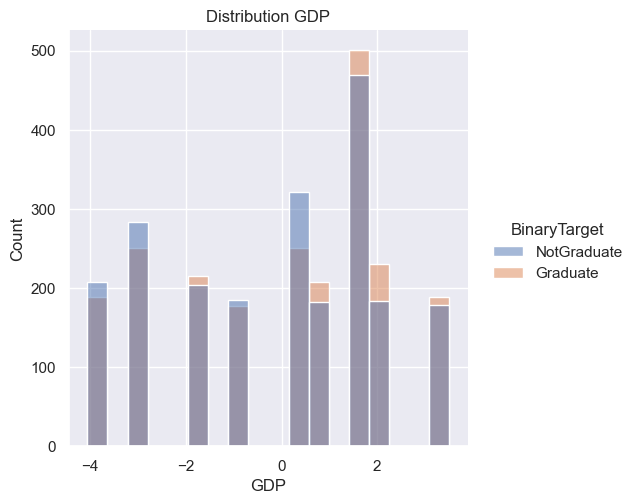

In [26]:
sns.displot(data, x=data.GDP, hue=data.BinaryTarget)
plt.title('Distribution GDP')
plt.show()

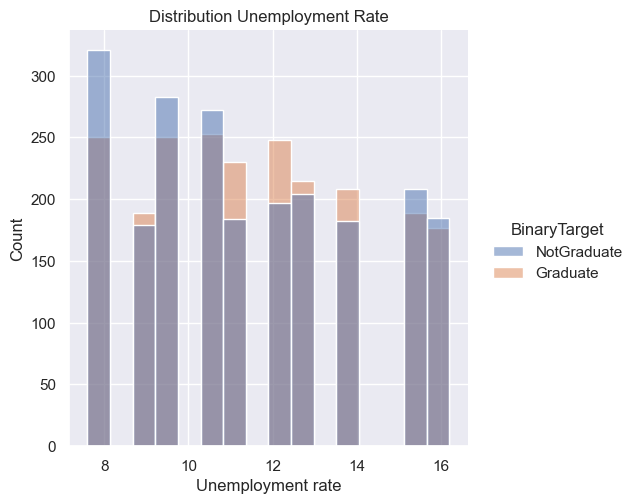

In [29]:
sns.displot(data, x=data['Unemployment rate'], hue=data.BinaryTarget)
plt.title('Distribution Unemployment Rate')
plt.show()

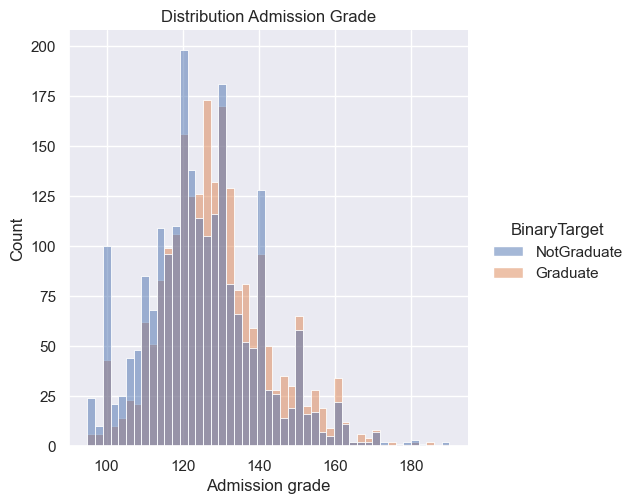

In [31]:
sns.displot(data, x=data['Admission grade'], hue=data.BinaryTarget)
plt.title('Distribution Admission Grade')
plt.show()

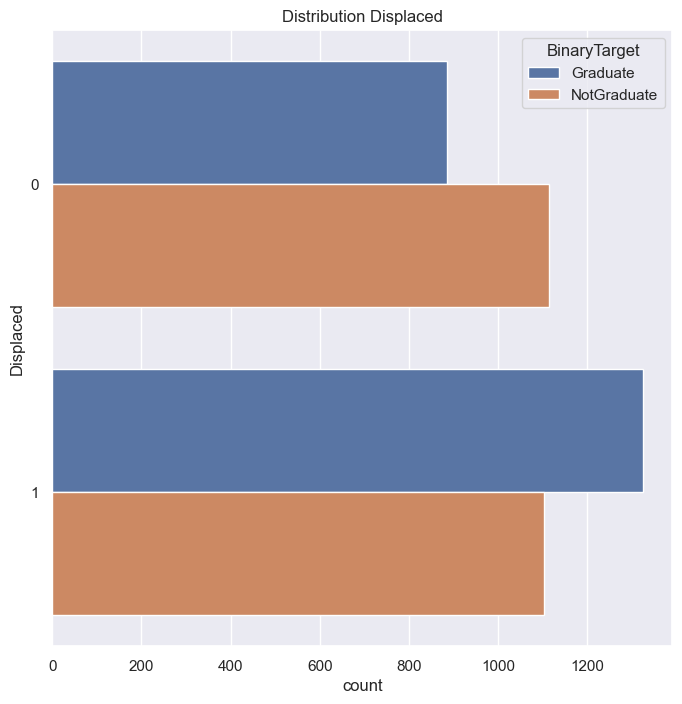

In [33]:
sns.countplot(data, y=data.Displaced, hue=data.BinaryTarget)
plt.title('Distribution Displaced')
plt.show()

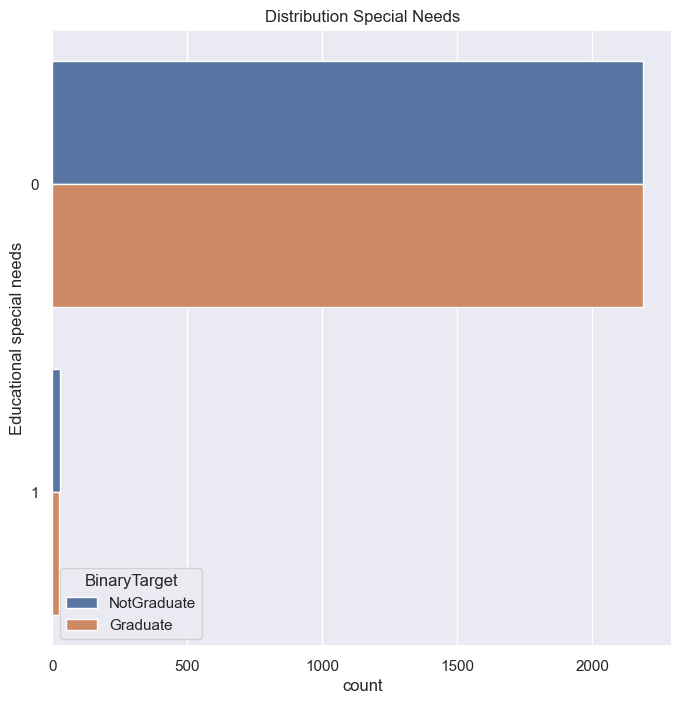

In [43]:
sns.countplot(data, y=data['Educational special needs'], hue=data.BinaryTarget)
plt.title('Distribution Special Needs')
plt.show()

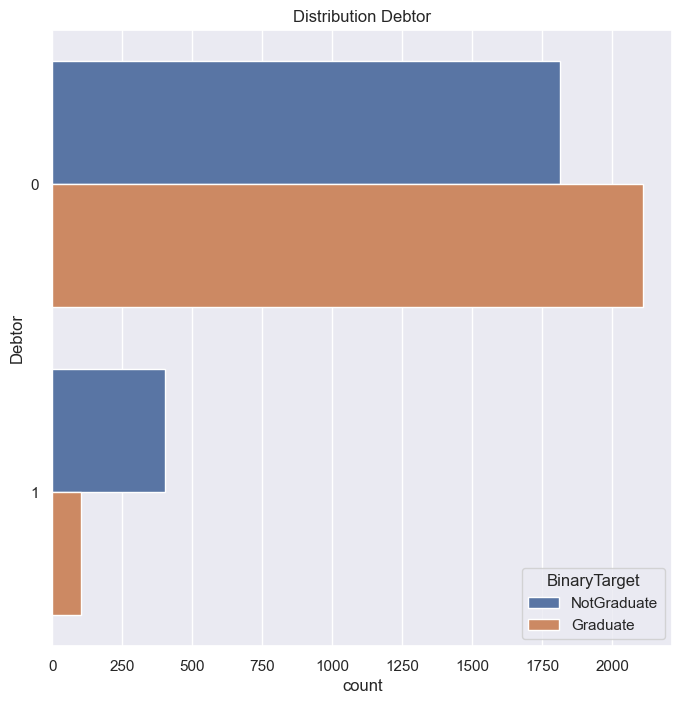

In [38]:
sns.countplot(data, y=data.Debtor, hue=data.BinaryTarget)
plt.title('Distribution Debtor')
plt.show()

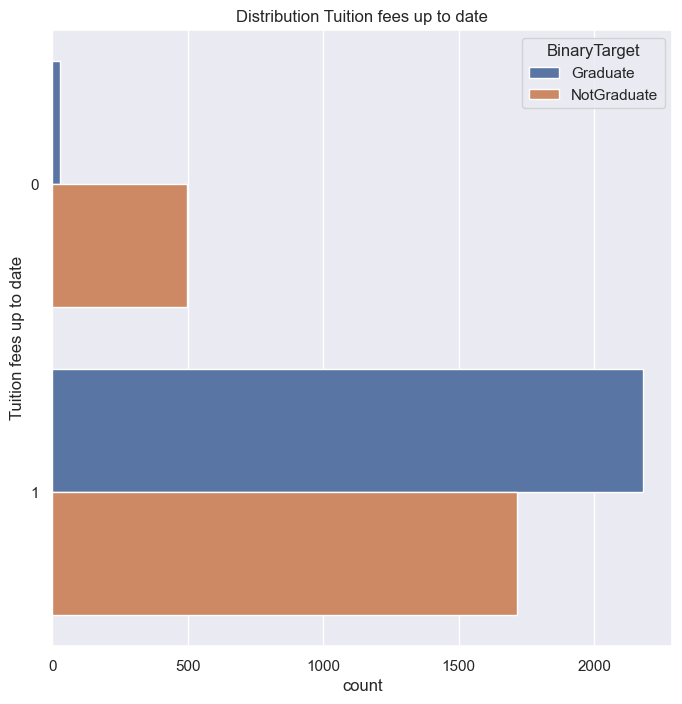

In [40]:
sns.countplot(data, y=data['Tuition fees up to date'], hue=data.BinaryTarget)
plt.title('Distribution Tuition fees up to date')
plt.show()

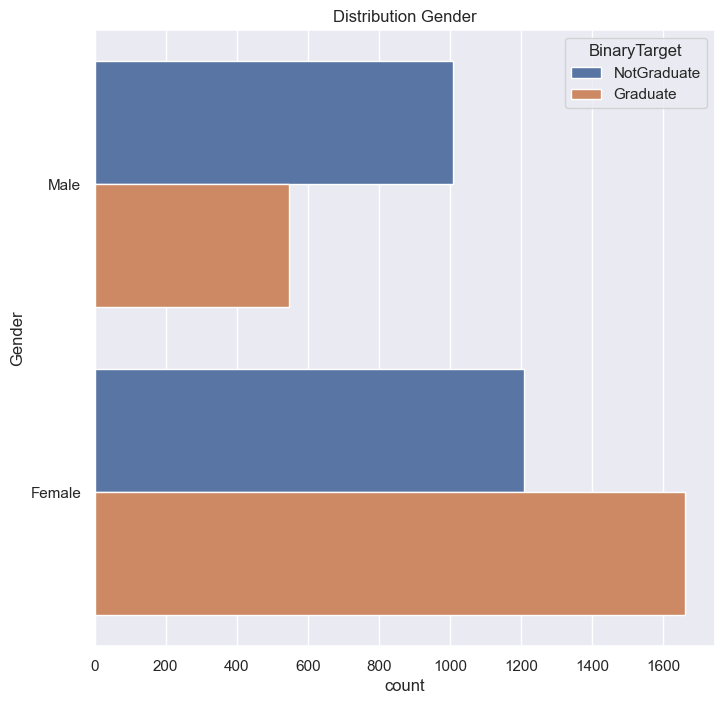

In [41]:
sns.countplot(data, y=data.Gender.replace({1:'Male',0:'Female'}), hue=data.BinaryTarget)
plt.title('Distribution Gender')
plt.show()

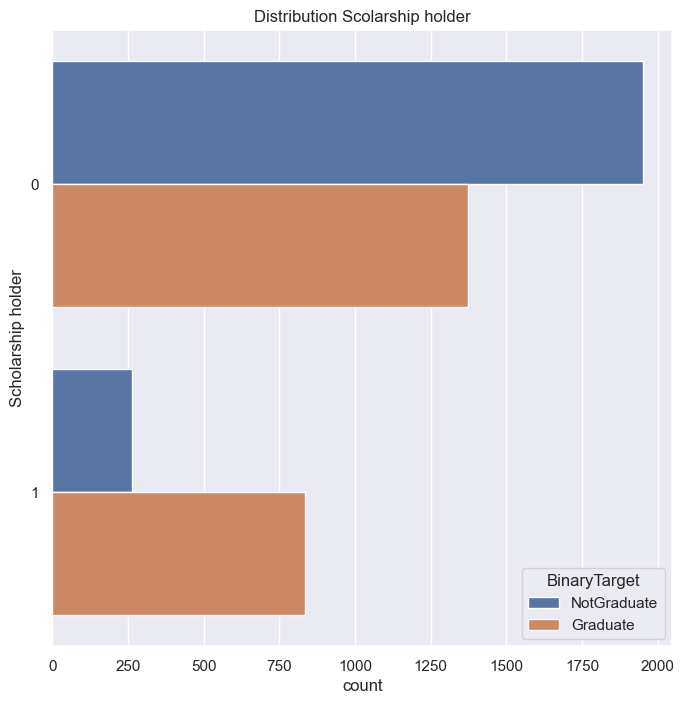

In [42]:
sns.countplot(data, y=data['Scholarship holder'], hue=data.BinaryTarget)
plt.title('Distribution Scolarship holder')
plt.show()

In [ ]:
sns.displot(data, x=data.Age_at_enrollment, hue=data.BinaryTarget)
plt.title('Distribution Age at Enrollment')
plt.show()

In [ ]:
sns.countplot(data, y=data.International)
plt.title('Distribution International')
plt.show()

## Bivariate Analysis
Explore the relationship between each feature and the target variable, perform statistical analysis to assess the significance of releationships between categorical variables and the target variable.


## Categorical Features

In [ ]:
# Function to perform bivariate analysis for categorical data
def bivariate_categorical_analysis(dataframe, column1, column2):
  # Count plot
  plt.figure(figsize=(8, 3))
  sns.countplot(x=column1, hue=column2, data=dataframe)
  plt.title(f'Count Plot: {column1} by {column2}')
  plt.xlabel(column1)
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.legend(title=column2)
  plt.show()

  # Cross-tabulation
  crosstab = pd.crosstab(dataframe[column1], dataframe[column2])
  print(f"Cross-tabulation between {column1} and {column2}:\n{crosstab}\n")

# Get the categorical columns
categorical_columns = data.iloc[:,[0,1,2,3,4,5,7,8,9,10,11,13,14,15,16,17,18,19,20]]

In [ ]:
# for column in categorical_columns:
#  bivariate_categorical_analysis(data, column, data.columns[-1])

In [ ]:
mapping = {
    1: '1st phase - general contingent',
    2: 'Ordinance No. 612/93',
    5: '1st phase - special contingent (Azores Island)',
    7: 'Holders of other higher courses',
    10: 'Ordinance No. 854-B/99',
    15: 'International student (bachelor)',
    16: '1st phase - special contingent (Madeira Island)',
    17: '2nd phase - general contingent',
    18: '3rd phase - general contingent',
    26: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    27: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    39: 'Over 23 years old',
    42: 'Transfer',
    43: 'Change of course',
    44: 'Technological specialization diploma holders',
    51: 'Change of institution/course',
    53: 'Short cycle diploma holders',
    57: 'Change of institution/course (International)'
}

mode = data['Application mode'].replace(mapping)
application_mode = pd.DataFrame({'Application mode': mode, 'Target': data['Target']})
# print(application_mode)

plt.figure(figsize=(12, 6))
sns.countplot(data=application_mode, y='Application mode', hue='BinaryTarget', palette='viridis')
plt.title('Distribution of Application Mode')
plt.ylabel('Application Mode')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Target', bbox_to_anchor=(1.1, 1), loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='Application order', hue='Target', palette='viridis')
plt.title('Distribution of Application Order')
plt.ylabel('Preference Order')
plt.xlabel('Count')
plt.show()

In [ ]:
mapping_course = {
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management (evening attendance)'
}

# Replace values in the 'Course' column using the mapping
course = data['Course'].replace(mapping_course)

# Combine 'Course' and 'Target' into a DataFrame
course_with_target = pd.DataFrame({'Course': course, 'Target': data['Target']})

# Plotting the bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=course_with_target, y='Course', hue='Target', palette='viridis')
plt.title('Distribution of Courses with Target')
plt.ylabel('Course')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
mapping_daytime_evening = {
    1: 'Daytime',
    0: 'Evening'
}

daytime_evening = data['Daytime/evening attendance\t'].replace(mapping_daytime_evening)
daytime_evening_with_target = pd.DataFrame({'Daytime/Evening Attendance': daytime_evening, 'Target': data['Target']})

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=daytime_evening_with_target, y='Daytime/Evening Attendance', hue='Target', palette='viridis')
plt.title('Distribution of Daytime/Evening Attendance')
plt.xlabel('Attendance')
plt.ylabel('Count')
plt.show()

In [ ]:
qualification_mapping = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: "Higher Education - Bachelor's Degree",
    3: 'Higher Education - Degree',
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    22: 'Technical-professional course',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    34: 'Unknown',
    35: "Can't read or write",
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

# Replace values in the 'Mother's qualification' column using the mapping
mother_qualification = data['Mother\'s qualification'].replace(qualification_mapping)
merged_data = pd.concat([mother_qualification, data['Target']], axis=1)

# Plotting the count plot for 'Mother's qualification' with hue and separated plots
plt.figure(figsize=(12, 8))
sns.countplot(data=merged_data, y='Mother\'s qualification', hue='Target', palette='viridis')
plt.title('Distribution of Mother\'s Qualification by Target')
plt.xlabel('Count')
plt.ylabel('Mother\'s Qualification')
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
qualification_mapping = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: "Higher Education - Bachelor's Degree",
    3: 'Higher Education - Degree',
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    13: '2nd year complementary high school course',
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    20: 'Complementary High School Course',
    22: 'Technical-professional course',
    25: 'Complementary High School Course - not concluded',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    31: 'General Course of Administration and Commerce',
    33: 'Supplementary Accounting and Administration',
    34: 'Unknown',
    35: "Can't read or write",
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

# Replace values in the 'Father's qualification' column using the mapping
father_qualification = data["Father's qualification"].replace(qualification_mapping)
merged_data = pd.concat([father_qualification, data['Target']], axis=1)

plt.figure(figsize=(12, 8))
sns.countplot(data=merged_data, y="Father's qualification", hue='Target', palette='viridis')
plt.title("Distribution of Father's Qualification by Target")
plt.xlabel('Count')
plt.ylabel("Father's Qualification")
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
occupation_mapping = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    122: 'Health professionals',
    123: 'Teachers',
    125: 'Specialists in information and communication technologies (ICT)',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    171: 'Skilled construction workers and the like, except electricians',
    173: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    191: 'Cleaning workers',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants'
}

mother_occupation = data["Mother's occupation"]
mother_occupation = mother_occupation.replace(occupation_mapping)
merged_data = pd.concat([mother_occupation, data['Target']], axis=1)

plt.figure(figsize=(12, 16))
sns.countplot(y="Mother's occupation", hue="Target", data=merged_data, palette='viridis')
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Mother's Occupation vs Target")
plt.xlabel("Count")
plt.ylabel("Mother's Occupation")
plt.show()

In [ ]:
father_occupation_mapping = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants',
    103: 'Other Armed Forces personnel',
    112: 'Directors of administrative and commercial services',
    114: 'Hotel, catering, trade and other services directors',
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    122: 'Health professionals',
    123: 'Teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel',
    161: 'Market-oriented farmers and skilled agricultural and animal production workers',
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar',
    174: 'Skilled workers in electricity and electronics',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators',
    182: 'Assembly workers',
    183: 'Vehicle drivers and mobile equipment operators',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers'
}

# Retrieve 'Father's occupation' column from the original dataset
father_occupation = data["Father's occupation"]

# Replace values in the 'Father's occupation' column using the mapping
father_occupation = father_occupation.replace(father_occupation_mapping)

# Merge 'Father's occupation' column with the target column
merged_data_father = pd.concat([father_occupation, data['Target']], axis=1)

# Plot
plt.figure(figsize=(12, 16))
sns.countplot(y="Father's occupation", hue="Target", data=merged_data_father, palette='viridis')
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Father's Occupation vs Target")
plt.xlabel("Count")
plt.ylabel("Father's Occupation")
plt.show()

## Continuous Features

In [ ]:
def bivariate_continuous_analysis(dataframe, continuous_column, categorical_column):
  # Box plot
  plt.figure(figsize=(8, 3))
  sns.kdeplot(data=dataframe,x=continuous_column, hue=categorical_column, fill=True, multiple='stack')
  plt.title(f'Box Plot: {continuous_column} by {categorical_column}')
  plt.xlabel(categorical_column)
  plt.ylabel(continuous_column)
  plt.xticks(rotation=45)
  plt.show()

# Get continuous Columns
continuous_cols = data.iloc[:,[6,12,21,22,23,24,25,25,27,28,29,30,31,32,33,34,35]]

In [ ]:
# for column in continuous_cols:
#  bivariate_continuous_analysis(data, column, data.columns[-1])

In [ ]:
curriculum_cols_1st = np.concatenate([data.columns[21:26], data.columns[-1:]])
curriculum_cols_2nd = np.concatenate([data.columns[27:33], data.columns[-1:]])

In [ ]:
sns.set(rc = {'figure.figsize':(32,32)})
curriculum_vars = data[curriculum_cols_1st]
curriculum_vars_renamed = curriculum_vars.rename(columns=dict(zip(curriculum_cols_1st, [col.replace('Curricular units', 'CU') for col in curriculum_cols_1st])))
sns.pairplot(curriculum_vars_renamed, hue='Target')
plt.suptitle("Curricular Units (CU) 1st Semester Pair Plot with Target ")

In [ ]:
sns.set(rc = {'figure.figsize':(32,32)})
curriculum_vars = data[curriculum_cols_2nd]
curriculum_vars_renamed = curriculum_vars.rename(columns=dict(zip(curriculum_cols_2nd, [col.replace('Curricular units', 'CU') for col in curriculum_cols_2nd])))
sns.pairplot(curriculum_vars_renamed, hue='Target')
plt.suptitle("Curricular Units (CU) 2nd Semester Pair Plot with Target ")

In [ ]:
sns.set(rc = {'figure.figsize':(8,8)})
avg_1st = data[curriculum_cols_1st[:-1]].mean(axis=1)
avg_2nd = data[curriculum_cols_2nd[:-1]].mean(axis=1)
sns.kdeplot(x=avg_1st, y=avg_2nd, hue=data['Target'], multiple='stack', fill=True, gridsize=100, levels=20, palette='viridis')
plt.xlabel("CU first semester")
plt.ylabel("CU second semester")
plt.title("KDE plot Curricular Units (CU) 1st vs 2nd semester")

## Multivariate Analysis

Examine interactiosn between multiple features, look for correlations between features to identify multicollinearity issues.

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
combined_df = pd.concat([father_qualification, mother_qualification], axis=1)
size = combined_df.groupby([combined_df.columns[0], combined_df.columns[1]]).size()
size = size.reset_index(name='Frequency')
size = size.sort_values(by='Frequency', ascending=False)
sns.scatterplot(x=size.columns[0], y=size.columns[1], hue=data['BinaryTarget'], size=size['Frequency'], sizes=(50, 300), data=size, alpha=0.7)
plt.title('Multivariate Frequency Plot of Father vs Mother Qualification')
plt.xlabel('Father Qualification')
plt.ylabel('Mother Qualification')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
combined_df = pd.concat([father_occupation, mother_occupation], axis=1)
size = combined_df.groupby([combined_df.columns[0], combined_df.columns[1]]).size()
size = size.reset_index(name='Frequency')
size = size.sort_values(by='Frequency', ascending=False)
sns.scatterplot(x=size.columns[0], y=size.columns[1], hue=data['BinaryTarget'], size=size['Frequency'], sizes=(50, 300), data=size, alpha=0.7)
plt.title('Frequency Plot of Father vs Mother Occupation')
plt.xlabel('Father Occupation')
plt.ylabel('Mother Occupation')
plt.tick_params(axis='x', rotation=90)
plt.show()

### Correlation Matrix Heatmap

In [ ]:
features = data.drop(columns=['Target'])
correlation_matrix = features.corr()

In [ ]:
sns.set(rc = {'figure.figsize':(32,16)})
sns.heatmap(correlation_matrix, annot = True, fmt='.2g', cmap= 'coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

### Feature Correlation

In [ ]:
high_corr_threshold = 0.7
high_corr_pairs = (correlation_matrix.abs() > high_corr_threshold) & (correlation_matrix != 1)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()].index.tolist()

In [ ]:
num_cols = 6
num_plots = len(high_corr_indices)
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

for i, (feature1, feature2) in enumerate(high_corr_indices):
    ax = axes[i // num_cols, i % num_cols]
    sns.scatterplot(x=feature1, y=feature2, data=data, ax=ax)
    ax.set_title(f'Pairplot for {feature1} and {feature2}', fontsize='x-small')

for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

## MANOVA

**Hypothesis**: We are testing whether there are significant differences among groups defined by the class variable ("Target") across all variables collectively and for each individual variable separately.

statsmodel seems to have some limitations in regards to the naming of the columns (no special characters except for "_"), so some formatting is done here.

In [ ]:
formatted_data = data
formatted_data.columns = [c.replace(' ', '_').replace('\'','').replace('(','').replace(')','').replace('/','_').strip() for c in formatted_data.columns]

Split the features and class data from each other.

In [ ]:
features = formatted_data.drop(columns=['Target'])
target = formatted_data['Target']

The MANOVA formula function only cares about the column names, so we'll only use that.

In [ ]:
vars = features.columns.to_numpy()

Setup the MANOVA formula "sum_of_all_variables ~ Class" over the data.

In [ ]:
manova = MANOVA.from_formula(' + '.join(vars) + ' ~ Target', data=formatted_data)

Perform the MANOVA test

In [ ]:
print(manova.mv_test())

#### Brief Discussion
##### Intercept
- **Hypothesis**: Whether there are significant differences among groups defined by the class variable across all variables collectively.
- **Discussion**: the $Pr > r$ values are all $1.000$, indicating that there is **NO** significant difference among groups for all variables. Suggesting that the class variable does not have a significant effect on the overall multivariate relationship with the other variables.

##### Target
- **Hypothesis**: Whether there are significant differences among groups defined by the class variable for each individual variable seperately.
- **Discussion**: The $Pr > r$ values are all $0.000$ indicating that there is a significant difference among groups for each individual variable. Suggesting that the class variable does have a significant effect on the multivariate relationship with each individual variable.

#### Conclusion on MANOVA
The result of the MANOVA analysis indicate that there are no significant differences among groups defined by the class variable across all variables collectively. However, there are significant differences among groups for each individual variable separately.
Therefore, we reject the null hypothesis for the individual variables, but fail to reject it for all variables collectively.

##### What does this mean for this use case?
Since there are significant differences among groups for each individual variable, it suggests that certain features may be more informative for discriminating between the classes. However, there is a lack of significant difference among groups across all variables collectively, implying that the overall multivariate relationship with the variables may not be strong, causing there to be features that may actually not be very informative.

We may look further into Feature Engineer, Dimensionality Reduction and optionally into PCA.
